In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *
import matplotlib.pylab as pylab
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 

In [2]:
#导入训练数据
train_df = pd.read_csv('../../data/round1_ijcai_18_train_20180301.txt', sep=' ')
train_df = train_df.applymap(lambda x: np.nan if (x==-1)|(x=='-1') else x)
print(train_df.info())
# print(train_df.head(10))
# print(train_df[['instance_id', 'item_id', 'item_brand_id']].head(10))

test_df = pd.read_csv('../../data/round1_ijcai_18_test_a_20180301.txt', sep=' ')
test_df = test_df.applymap(lambda x: np.nan if (x==-1)|(x=='-1') else x)
print(test_df.info())
# print(test_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478138 entries, 0 to 478137
Data columns (total 27 columns):
instance_id                  478138 non-null int64
item_id                      478138 non-null int64
item_category_list           478138 non-null object
item_property_list           478138 non-null object
item_brand_id                477665 non-null float64
item_city_id                 477861 non-null float64
item_price_level             478138 non-null int64
item_sales_level             477225 non-null float64
item_collected_level         478138 non-null int64
item_pv_level                478138 non-null int64
user_id                      478138 non-null int64
user_gender_id               465236 non-null float64
user_age_level               477174 non-null float64
user_occupation_id           477174 non-null float64
user_star_level              477174 non-null float64
context_id                   478138 non-null int64
context_timestamp            478138 non-null int64
contex

In [3]:
#查看正负样本个数及比例
print('正样本个数 ： ' + str(len(train_df[train_df.is_trade == 1])))
print('负样本个数 ： ' + str(len(train_df[train_df.is_trade == 0])))
print('正负样本比例 ： ' + str(len(train_df[train_df.is_trade == 1]) / len(train_df[train_df.is_trade == 0])))

正样本个数 ： 9021
负样本个数 ： 469117
正负样本比例 ： 0.019229744392123927


In [17]:
#尝试将时间戳转化为日期
# train_df['date'] = train_df.context_timestamp.map(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S"))
train_df['date'] = train_df.context_timestamp.map(lambda x: datetime.datetime.fromtimestamp(x))
train_df = train_df.sort_values(by = 'date', ascending = True)
print('train_max_date : ', train_df.iloc[len(train_df) -1]['date']) 
print('train_min_date : ', train_df.iloc[0]['date'])
print(train_df[['date', 'context_timestamp']].head(10))
test_df['date'] = test_df.context_timestamp.map(lambda x: datetime.datetime.fromtimestamp(x))
test_df = test_df.sort_values(by = 'date', ascending = True)
print(test_df[['date', 'context_timestamp']].head(10))

#输出训练集时间跨度
print('train set deltaTime：', (train_df.iloc[len(train_df) -1]['date'] - train_df.iloc[0]['date']))
print('test set deltaTime：', (test_df.iloc[len(test_df) -1]['date'] - test_df.iloc[0]['date']))

train_max_date :  2018-09-24 23:59:47
train_min_date :  2018-09-18 00:00:01
                     date  context_timestamp
3844  2018-09-18 00:00:01         1537200001
24046 2018-09-18 00:00:04         1537200004
59329 2018-09-18 00:00:05         1537200005
70767 2018-09-18 00:00:11         1537200011
76650 2018-09-18 00:00:14         1537200014
27196 2018-09-18 00:00:14         1537200014
59196 2018-09-18 00:00:16         1537200016
57458 2018-09-18 00:00:16         1537200016
23301 2018-09-18 00:00:17         1537200017
24479 2018-09-18 00:00:17         1537200017
                     date  context_timestamp
6594  2018-09-25 00:00:02         1537804802
2782  2018-09-25 00:00:20         1537804820
9049  2018-09-25 00:00:25         1537804825
13921 2018-09-25 00:00:29         1537804829
6324  2018-09-25 00:00:31         1537804831
12064 2018-09-25 00:00:31         1537804831
3087  2018-09-25 00:00:36         1537804836
5986  2018-09-25 00:00:38         1537804838
2237  2018-09-25 00:00:3

20
20


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


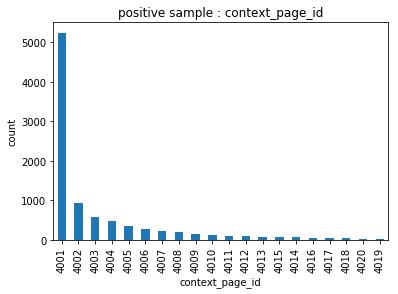

page_proportion_1 : 0.01443298969072165


'\n(1)、由图可以大致看出，产生交易的记录，大部分是产生于第一页的搜索，前5页比重还比较大，因此，前5页采用onehot编码，6-10页作为一个特征，10-20页作为一个特征\n(2)、训练集对于每个page_id中正样本个数所占比例大致相近，都是百分之1到百分之2之间\n'

In [37]:
#分析广告商品展示页面编号与是否交易的关系
#输出所有的页面编号种类
print(len(train_df['context_page_id'].drop_duplicates()))
print(len(train_df['context_page_id'][train_df.is_trade == 1].drop_duplicates()))

#查看正样本依据context_page_id的分布
train_df_positive_page = train_df[['context_page_id']][train_df.is_trade == 1]
train_df_positive_page.context_page_id.value_counts().plot(kind='bar')   # 柱状图 
plt.title(u"positive sample : context_page_id") # 标题
plt.ylabel(u"count") 
plt.xlabel(u"context_page_id") 

plt.show()

#定义获取某个page_id下正样本比例
def getPositiveProportionPage(df, context_page_id):
    page_proportion = len(df['context_page_id'][(df.context_page_id == context_page_id) & (df.is_trade == 1)]) / len(df['context_page_id'][(df.context_page_id == context_page_id)])
    return page_proportion

page_proportion_1 = getPositiveProportionPage(train_df, 4020)
print('page_proportion_1 : ' + str(page_proportion_1))
'''
(1)、由图可以大致看出，产生交易的记录，大部分是产生于第一页的搜索，前5页比重还比较大，因此，前5页采用onehot编码，6-10页作为一个特征，10-20页作为一个特征
(2)、训练集对于每个page_id中正样本个数所占比例大致相近，都是百分之1到百分之2之间
'''

2055
872
1101
在测试集却不在训练集的品牌数： 21
{nan, 3.4432875282115144e+18, 5.5846485733997005e+18, 7.0429152538739487e+18, 1.2953269899093681e+18, 5.9472364217026959e+18, 7.1898175882672394e+18, 2.3679452401295713e+18, 1.2654395498135578e+18, 2.4172558500890609e+18, 9.0595984925661225e+18, 6.4441884007399373e+18, 7.5839691417133097e+18, 4.5936988481170186e+18, 8.4391055187254149e+18, 1.924896087747605e+18, 1.2544884576638986e+18, 7.8236760922906388e+18, 5.0608213746758349e+18, 8.4238714335384197e+18, 4.6836496585763174e+17}


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


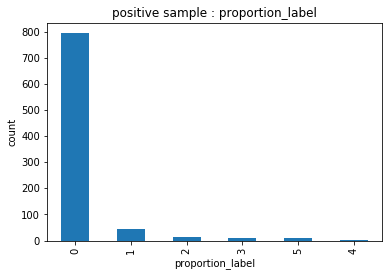

24
72
       item_brand_id  positive_counts  all_counts  proportion  \
6587    6.793286e+18              179        5280    0.033902   
14762   7.838285e+18             1505       69746    0.021578   
13720   5.051040e+18              359       13045    0.027520   
15554   6.350720e+16               88        1377    0.063907   
12657   6.986650e+17               21        1251    0.016787   
24494   5.552377e+18               10        1207    0.008285   
53618   8.828795e+18                8         757    0.010568   
73239   3.001778e+18               21         861    0.024390   
37105   3.572662e+18                5         271    0.018450   
61111   5.239370e+18               24         558    0.043011   

       proportion_label  
6587                  0  
14762                 0  
13720                 0  
15554                 0  
12657                 0  
24494                 0  
53618                 0  
73239                 0  
37105                 0  
61111             

'\n(1)、可以看到，大部分测试集的品牌，在训练集中都出现过，因此，可以把在训练集中没出现过的品牌归到转正率为0的类别中，即归到proportion_label为0中\n(2)、由图可以看出，大部分的品牌的转正率都在百分之10以下\n'

In [38]:
#分析广告商品品牌与交易的关系
#输出所有的品牌编号种类
print(len(train_df['item_brand_id'].drop_duplicates()))
print(len(train_df['item_brand_id'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_brand_id'].drop_duplicates()))

#查看训练集和测试集品牌id的交叉情况
train_brand_set = set(train_df['item_brand_id'].drop_duplicates())
test_brand_set = set(test_df['item_brand_id'].drop_duplicates())
print('在测试集却不在训练集的品牌数：', len(test_brand_set - train_brand_set))
print(test_brand_set - train_brand_set)

train_df_positive_brand = train_df[['item_brand_id']][train_df.is_trade == 1].drop_duplicates()
train_df_positive_brand['positive_counts'] = train_df_positive_brand['item_brand_id'].map(lambda x: len(train_df['item_brand_id'][(train_df.is_trade == 1) & (train_df.item_brand_id == x)])) 
train_df_positive_brand['all_counts'] = train_df_positive_brand['item_brand_id'].map(lambda x: len(train_df['item_brand_id'][(train_df.item_brand_id == x)])) 
train_df_positive_brand['proportion'] = train_df_positive_brand['positive_counts'] / train_df_positive_brand['all_counts']

train_df_positive_brand['proportion_label'] = train_df_positive_brand.proportion.map(lambda x: 0 if math.isnan(x) else int(x * 10))
train_df_positive_brand['proportion_label'] = train_df_positive_brand.proportion_label.map(lambda x: 5 if x >= 5 else x)
train_df_positive_brand.proportion_label.value_counts().plot(kind='bar')   # 柱状图 
plt.title(u"positive sample : proportion_label") # 标题
plt.ylabel(u"count") 
plt.xlabel(u"proportion_label") 
plt.show()

print(len(train_df_positive_brand[train_df_positive_brand.positive_counts > 50]))
print(len(train_df_positive_brand[train_df_positive_brand.proportion > 0.1]))
print(train_df_positive_brand.head(10))

'''
(1)、可以看到，大部分测试集的品牌，在训练集中都出现过，因此，可以把在训练集中没出现过的品牌归到转正率为0的类别中，即归到proportion_label为0中
(2)、由图可以看出，大部分的品牌的转正率都在百分之10以下
'''

128
87
99
在测试集却不在训练集的城市数： 1
{nan}


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


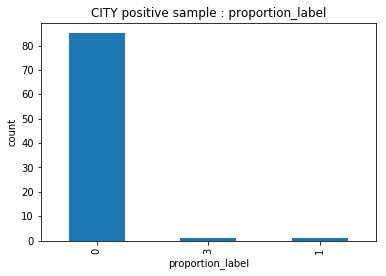

              item_id  item_city_id  proportion
item_city_id                                   
3.334405e+17        1  3.334405e+17    0.055556
9.830067e+17       43  9.830067e+17    0.058904
2.441251e+18        3  2.441251e+18    0.071429
3.660952e+18        1  3.660952e+18    0.066667
4.228028e+18        1  4.228028e+18    0.333333
4.350273e+18       12  4.350273e+18    0.069364
4.385376e+18       15  4.385376e+18    0.076531
4.696414e+18        2  4.696414e+18    0.051282
7.296768e+18        3  7.296768e+18    0.136364
7.968876e+18        1  7.968876e+18    0.076923
8.201344e+18        4  8.201344e+18    0.072727
8.933803e+18        1  8.933803e+18    0.076923


'\n(1)、可以看到，大部分测试集的城市，在训练集中都出现过，由于转正率感觉不是很大作用，暂且选择一些交易成功数量较大的城市标为标签\n(2)、由图可以看出，大部分的城市的转正率都在百分之10以下，而且转化率在百分之10以上的都是少数城市，不排除是数据量的问题\n'

In [39]:
#分析城市编号item_city_id字段的影响
#首先查看训练集和测试集城市编号种类个数
print(len(train_df['item_city_id'].drop_duplicates()))
print(len(train_df['item_city_id'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_city_id'].drop_duplicates()))

#查看训练集和测试集城市id的交叉情况
train_city_set = set(train_df['item_city_id'].drop_duplicates())
test_city_set = set(test_df['item_city_id'].drop_duplicates())
print('在测试集却不在训练集的城市数：', len(test_city_set - train_city_set))
print(test_city_set - train_city_set)

train_df_positive_city = train_df[['item_city_id']][train_df.is_trade == 1].drop_duplicates()
train_df_positive_city['positive_counts'] = train_df_positive_city['item_city_id'].map(lambda x: len(train_df['item_city_id'][(train_df.is_trade == 1) & (train_df.item_city_id == x)])) 
train_df_positive_city['all_counts'] = train_df_positive_city['item_city_id'].map(lambda x: len(train_df['item_city_id'][(train_df.item_city_id == x)])) 
train_df_positive_city['proportion'] = train_df_positive_city['positive_counts'] / train_df_positive_city['all_counts']

train_df_positive_city['proportion_label'] = train_df_positive_city.proportion.map(lambda x: 0 if math.isnan(x) else int(x * 10))
train_df_positive_city['proportion_label'] = train_df_positive_city.proportion_label.map(lambda x: 5 if x >= 5 else x)
train_df_positive_city.proportion_label.value_counts().plot(kind='bar')   # 柱状图 
plt.title(u"CITY positive sample : proportion_label") # 标题
plt.ylabel(u"count") 
plt.xlabel(u"proportion_label") 
plt.show()

train_city_positive_pivot_table = pd.pivot_table(train_df[['item_id', 'item_city_id']][train_df.is_trade == 1], index = ['item_city_id'], values = ['item_id'], aggfunc = {'item_id' : len})
train_city_positive_pivot_table['item_city_id'] = train_city_positive_pivot_table.index
train_city_positive_pivot_table['proportion'] = train_city_positive_pivot_table.item_city_id.map(lambda x: train_df_positive_city.proportion[train_df_positive_city.item_city_id == x].values[0])
# train_city_positive_pivot_table.reset_index(inplace=True)
print(train_city_positive_pivot_table[(train_city_positive_pivot_table.item_id > 0) & (train_city_positive_pivot_table.proportion > 0.05)].head(20))

'''
(1)、可以看到，大部分测试集的城市，在训练集中都出现过，由于转正率感觉不是很大作用，暂且选择一些交易成功数量较大的城市标为标签
(2)、由图可以看出，大部分的城市的转正率都在百分之10以下，而且转化率在百分之10以上的都是少数城市，不排除是数据量的问题
'''


In [40]:
#查看广告商品价格等级item_price_level的影响
#首先查看训练集和测试集广告商品价格等级种类个数
print(len(train_df['item_price_level'].drop_duplicates()))
print(len(train_df['item_price_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_price_level'].drop_duplicates()))

#查看训练集和测试集广告商品价格等级的交叉情况
train_price_level_set = set(train_df['item_price_level'].drop_duplicates())
test_price_level_set = set(test_df['item_price_level'].drop_duplicates())
print('在测试集却不在训练集的广告商品价格等级数：', len(test_price_level_set - train_price_level_set))

train_price_level_pivot_table = pd.pivot_table(train_df[['item_id', 'item_price_level', 'is_trade']], index=['item_price_level', 'is_trade'], values=['item_id'], aggfunc = {'item_id' : len})
print(train_price_level_pivot_table.head(100))

'''
(1)、可以看到，所有在测试集中出现过的广告商品价格等级都在训练集中出现过
(2)、通过透视表可以看到，在价格等级较低或者较高的时候点击次数都是比较少，特别是对于较高的价格，基本不会有人购买，因此，可以采取onehot编码
'''

14
10
10
在测试集却不在训练集的广告商品价格等级数： 0
                           item_id
item_price_level is_trade         
0                0              11
                 1               1
1                0              80
                 1               5
2                0             330
                 1              17
3                0            3416
                 1             171
4                0           13881
                 1             726
5                0           39787
                 1            1270
6                0           86996
                 1            2061
7                0          206099
                 1            3186
8                0          114034
                 1            1553
9                0            4004
                 1              31
10               0             456
11               0              21
16               0               1
17               0               1


'\n(1)、可以看到，所有在测试集中出现过的广告商品价格等级都在训练集中出现过\n(2)、通过透视表可以看到，在价格等级较低或者较高的时候点击次数都是比较少，特别是对于较高的价格，基本不会有人购买，因此，可以采取onehot编码\n'

In [41]:
#查看广告商品销量等级item_sales_level的影响
#首先查看训练集和测试集广告商品销量等级种类个数
print(len(train_df['item_sales_level'].drop_duplicates()))
print(len(train_df['item_sales_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_sales_level'].drop_duplicates()))

train_sales_level_pivot_table = pd.pivot_table(train_df[['item_id', 'item_sales_level', 'is_trade']], index=['item_sales_level', 'is_trade'], values=['item_id'], aggfunc = {'item_id' : len})
print(train_sales_level_pivot_table.head(100))

'''
(1)、可以看到，所有在测试集中出现过的广告商品销量等级都在训练集中出现过
(2)、通过透视表可以看到，在销量等级较低或者较高的时候点击次数都是比较少，不过按常理来说，应该销量高一点的话点击得应该也是越多的，此处有点疑惑。
初步做法，先采取onehot编码，后期可以考虑提取一些点击量和转正率都较高的特征，比如销量等级从10到14
(3)、注意这个字段存在缺失值，先把缺失值当作一种类型处理
'''

18
18
18
                           item_id
item_sales_level is_trade         
1.0              0             496
                 1               5
2.0              0             945
                 1               5
3.0              0            1824
                 1              20
4.0              0            3208
                 1              22
5.0              0            5681
                 1              58
6.0              0           10920
                 1             114
7.0              0           17802
                 1             228
8.0              0           26605
                 1             364
9.0              0           39106
                 1             532
10.0             0           56788
                 1             876
11.0             0           79014
                 1            1426
12.0             0           85276
                 1            1684
13.0             0           63009
                 1            1442
14.0       

'\n(1)、可以看到，所有在测试集中出现过的广告商品销量等级都在训练集中出现过\n(2)、通过透视表可以看到，在销量等级较低或者较高的时候点击次数都是比较少，不过按常理来说，应该销量高一点的话点击得应该也是越多的，此处有点疑惑。\n初步做法，先采取onehot编码，后期可以考虑提取一些点击量和转正率都较高的特征，比如销量等级从10到14\n(3)、注意这个字段存在缺失值，先把缺失值当作一种类型处理\n'

In [42]:
#查看广告商品被收藏次数等级item_collected_level的影响
#首先查看训练集和测试集广告商品被收藏次数等级种类个数
print(len(train_df['item_collected_level'].drop_duplicates()))
print(len(train_df['item_collected_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_collected_level'].drop_duplicates()))

train_collected_level_pivot_table = pd.pivot_table(train_df[['item_id', 'item_collected_level', 'is_trade']], index=['item_collected_level', 'is_trade'], values=['item_id'], aggfunc = {'item_id' : len})
print(train_collected_level_pivot_table.head(100))

'''
(1)、可以看到，所有在测试集中出现过的广告商品被收藏次数等级都在训练集中出现过
(2)、类似与广告商品销量等级item_sales_level字段，都是在较低等级的时候点击率和转正率都比较低，在十几级达到高峰后会出现下降现象
初步做法，先采取onehot编码，后期可以考虑提取一些点击量和转正率都较高的特征，比如销量等级从10到15
'''

18
18
18
                               item_id
item_collected_level is_trade         
0                    0             277
                     1               2
1                    0             265
                     1               2
2                    0             482
                     1              10
3                    0             929
                     1              10
4                    0            1716
                     1              20
5                    0            2770
                     1              34
6                    0            5277
                     1              95
7                    0           10305
                     1             133
8                    0           16205
                     1             238
9                    0           23570
                     1             429
10                   0           41257
                     1             796
11                   0           52054
                

'\n(1)、可以看到，所有在测试集中出现过的广告商品被收藏次数等级都在训练集中出现过\n(2)、类似与广告商品销量等级item_sales_level字段，都是在较低等级的时候点击率和转正率都比较低，在十几级达到高峰后会出现下降现象\n初步做法，先采取onehot编码，后期可以考虑提取一些点击量和转正率都较高的特征，比如销量等级从10到15\n'

In [43]:
#查看广告商品被展示次数等级item_collected_level的影响
#首先查看训练集和测试集广告商品被展示次数等级种类个数
print(len(train_df['item_pv_level'].drop_duplicates()))
print(len(train_df['item_pv_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['item_pv_level'].drop_duplicates()))

#查看训练集和测试集广告商品被展示次数等级item_pv_level的交叉情况
train_pv_level_set = set(train_df['item_pv_level'].drop_duplicates())
test_pv_level_set = set(test_df['item_pv_level'].drop_duplicates())
print('在测试集却不在训练集的广告商品被展示次数等级item_pv_level数：', len(test_pv_level_set - train_pv_level_set))
print(test_pv_level_set - train_pv_level_set)

train_pv_level_pivot_table = pd.pivot_table(train_df[['item_id', 'item_pv_level', 'is_trade']], index=['item_pv_level', 'is_trade'], values=['item_id'], aggfunc = {'item_id' : len})
print(train_pv_level_pivot_table.head(100))

'''
(1)、可以看到，所有在测试集中出现过的广告商品被展示次数等级item_collected_level都在训练集中出现过
(2)、通过透视表可以看到，基本上随着等级的升高，点击量和转正率都会升高
'''

22
17
21
在测试集却不在训练集的广告商品被展示次数等级item_pv_level数： 0
set()
                        item_id
item_pv_level is_trade         
0             0             122
              1               1
1             0               1
2             0               5
3             0              10
              1               1
4             0              33
5             0              63
6             0             116
7             0             242
              1               3
8             0             444
              1               5
9             0             905
              1               8
10            0            1808
              1              37
11            0            3821
              1              64
12            0            7184
              1             108
13            0           13564
              1             264
14            0           25091
              1             457
15            0           40734
              1             745
16            0  

'\n(1)、可以看到，所有在测试集中出现过的广告商品被展示次数等级item_collected_level都在训练集中出现过\n(2)、通过透视表可以看到，基本上随着等级的升高，点击量和转正率都会升高\n'

In [44]:
#分析用户的预测性别编号user_gender_id的影响
#首先查看训练集和测试集预测性别编号user_gender_id种类个数
print(len(train_df['user_gender_id'].drop_duplicates()))
print(len(train_df['user_gender_id'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['user_gender_id'].drop_duplicates()))

train_user_gender_pivot_table = pd.pivot_table(train_df[['user_id', 'user_gender_id', 'is_trade']], index=['user_gender_id', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_user_gender_pivot_table.head(100))

'''
(1)、可以看到，在训练集中，女性用户通常会比男性用户点击次数多，男性用户转正率会相对来说高一点
(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点
'''

4
4
4
                         user_id
user_gender_id is_trade         
0.0            0          354151
               1            6666
1.0            0           92076
               1            1994
2.0            0           10154
               1             195


'\n(1)、可以看到，在训练集中，女性用户通常会比男性用户点击次数多，男性用户转正率会相对来说高一点\n(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点\n'

In [45]:
#分析用户的预测年龄等级user_age_level的影响
#首先查看训练集和测试集预测年龄等级user_age_level种类个数
print(len(train_df['user_age_level'].drop_duplicates()))
print(len(train_df['user_age_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['user_age_level'].drop_duplicates()))

train_user_age_pivot_table = pd.pivot_table(train_df[['user_id', 'user_age_level', 'is_trade']], index=['user_age_level', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_user_age_pivot_table.head(100))

'''
(1)、可以看到，在训练集中，当年龄等级升高至1003和1004附近时达到较高点
(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点
'''

9
9
9
                         user_id
user_age_level is_trade         
1000.0         0           12781
               1             177
1001.0         0            6361
               1              85
1002.0         0           69061
               1            1114
1003.0         0          166444
               1            3005
1004.0         0          123611
               1            2520
1005.0         0           55268
               1            1340
1006.0         0           29543
               1             647
1007.0         0            5096
               1             121


'\n(1)、可以看到，在训练集中，当年龄等级升高至1003和1004附近时达到较高点\n(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点\n'

In [46]:
#分析用户的预测职业编号user_occupation_id的影响
#首先查看训练集和测试集预测职业编号user_occupation_id种类个数
print(len(train_df['user_occupation_id'].drop_duplicates()))
print(len(train_df['user_occupation_id'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['user_occupation_id'].drop_duplicates()))

train_user_occupation_pivot_table = pd.pivot_table(train_df[['user_id', 'user_occupation_id', 'is_trade']], index=['user_occupation_id', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_user_occupation_pivot_table.head(100))

'''
(1)、可以看到，在训练集中，对于职业2002和2005来说，点击量和点击率都比较高
(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点
'''

5
5
5
                             user_id
user_occupation_id is_trade         
2002.0             0          143932
                   1            2985
2003.0             0            6332
                   1              86
2004.0             0           23363
                   1             440
2005.0             0          294538
                   1            5498


'\n(1)、可以看到，在训练集中，对于职业2002和2005来说，点击量和点击率都比较高\n(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点\n'

In [47]:
#分析用户的星级编号user_star_level的影响
#首先查看训练集和测试集用户的星级编号user_star_level种类个数
print(len(train_df['user_star_level'].drop_duplicates()))
print(len(train_df['user_star_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['user_star_level'].drop_duplicates()))

train_user_star_pivot_table = pd.pivot_table(train_df[['user_id', 'user_star_level', 'is_trade']], index=['user_star_level', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_user_star_pivot_table.head(100))

'''
(1)、可以看到，在训练集中，对于用户星级在3002到3007时，点击量和转正率相对来说高一点
(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点
'''

12
12
12
                          user_id
user_star_level is_trade         
3000.0          0           30962
                1             374
3001.0          0           18976
                1             349
3002.0          0           61675
                1            1246
3003.0          0           73129
                1            1449
3004.0          0           60552
                1            1217
3005.0          0           66177
                1            1263
3006.0          0           80434
                1            1575
3007.0          0           52266
                1            1049
3008.0          0           19786
                1             392
3009.0          0            4034
                1              90
3010.0          0             174
                1               5


'\n(1)、可以看到，在训练集中，对于用户星级在3002到3007时，点击量和转正率相对来说高一点\n(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点\n'

In [48]:
#分析店铺的评价数量等级的影响
#首先查看训练集和测试集店铺的评价数量等级shop_review_num_level种类个数
print(len(train_df['shop_review_num_level'].drop_duplicates()))
print(len(train_df['shop_review_num_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['shop_review_num_level'].drop_duplicates()))

train_shop_review_num_level_pivot_table = pd.pivot_table(train_df[['shop_id', 'shop_review_num_level', 'is_trade']], index=['shop_review_num_level', 'is_trade'], values=['shop_id'], aggfunc = {'shop_id' : len})
print(train_shop_review_num_level_pivot_table.head(100))

'''
(1)、总体来说，随着店铺评价数量的增加，点击量和转正率都会上升，在17附近会下降，14-18点击量较大
(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点
'''

25
22
21
                                shop_id
shop_review_num_level is_trade         
0                     0               7
1                     0              20
2                     0              85
                      1               2
3                     0              79
                      1               1
4                     0             263
                      1               3
5                     0             572
                      1               6
6                     0            1316
                      1              27
7                     0            1817
                      1              32
8                     0            3034
                      1              55
9                     0            5354
                      1             130
10                    0            8463
                      1             135
11                    0           13768
                      1             240
12                    0        

'\n(1)、总体来说，随着店铺评价数量的增加，点击量和转正率都会上升，在17附近会下降，14-18点击量较大\n(2)、暂且先采用onehot处理，后期要和其他特征进行交叉处理估计效果会好点\n'

In [49]:
#分析店铺星级编号的影响
#首先查看训练集和测试集店铺的星级编号shop_star_level种类个数
print(len(train_df['shop_star_level'].drop_duplicates()))
print(len(train_df['shop_star_level'][train_df.is_trade == 1].drop_duplicates()))
print(len(test_df['shop_star_level'].drop_duplicates()))

train_shop_star_level_pivot_table = pd.pivot_table(train_df[['shop_id', 'shop_star_level', 'is_trade']], index=['shop_star_level', 'is_trade'], values=['shop_id'], aggfunc = {'shop_id' : len})
print(train_shop_star_level_pivot_table.head(100))


22
21
20
                          shop_id
shop_star_level is_trade         
4999            0               7
5000            0              80
                1               1
5001            0              58
                1               2
5002            0             471
                1               6
5003            0            1246
                1              20
5004            0             844
                1              19
5005            0            1438
                1              21
5006            0            3030
                1              57
5007            0            5371
                1             129
5008            0            8343
                1             137
5009            0           17894
                1             297
5010            0           24071
                1             416
5011            0           33804
                1             552
5012            0           72331
                1            1280
5013 

In [50]:
#查看用户相关特征的分布
train_user_pivot_table = pd.pivot_table(train_df[['user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'is_trade']], index=['user_gender_id', 'user_age_level', 'user_occupation_id', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_user_pivot_table.head(100))


                                                           user_id
user_gender_id user_age_level user_occupation_id is_trade         
0.0            1000.0         2002.0             0             440
                                                 1               6
                              2003.0             0               9
                              2004.0             0              59
                              2005.0             0            2126
                                                 1              19
               1001.0         2002.0             0             755
                                                 1               6
                              2003.0             0            1219
                                                 1              21
                              2004.0             0             160
                                                 1               2
                              2005.0             0            

In [51]:
#查看店铺好评率与是否交易间的关系，标记是否高于平均水平
print(len(train_df))
print(len(train_df.drop_duplicates('shop_id')))
shop_review_positive_rate_ave = train_df['shop_review_positive_rate'][train_df.is_trade == 1].mean()
train_df['isHigh_shop_review_positive_rate'] = train_df['shop_review_positive_rate'].map(lambda x: 1 if x >= shop_review_positive_rate_ave else 0)
print(shop_review_positive_rate_ave)

train_isHigh_shop_review_positive_rate_pivot_table = pd.pivot_table(train_df[['user_id', 'isHigh_shop_review_positive_rate', 'is_trade']], index=['isHigh_shop_review_positive_rate', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_isHigh_shop_review_positive_rate_pivot_table.head(100))

478138
3959
0.9933314255939395
                                           user_id
isHigh_shop_review_positive_rate is_trade         
0                                0          123918
                                 1            3142
1                                0          345199
                                 1            5879


In [52]:
#查看店铺的服务态度评分与是否交易间的关系，标记是否高于平均水平
shop_score_service_ave = train_df['shop_score_service'][train_df.is_trade == 1].mean()
train_df['isHigh_shop_score_service'] = train_df['shop_score_service'].map(lambda x: 1 if x >= shop_score_service_ave else 0)
print(shop_score_service_ave)

train_isHigh_shop_score_service_pivot_table = pd.pivot_table(train_df[['user_id', 'isHigh_shop_score_service', 'is_trade']], index=['isHigh_shop_score_service', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_isHigh_shop_score_service_pivot_table.head(100))

0.969103023835867
                                    user_id
isHigh_shop_score_service is_trade         
0                         0          167686
                          1            4351
1                         0          301431
                          1            4670


In [53]:
#查看店铺的物流服务评分与是否交易间的关系，标记是否高于平均水平
shop_score_delivery_ave = train_df['shop_score_delivery'][train_df.is_trade == 1].mean()
train_df['isHigh_shop_score_delivery'] = train_df['shop_score_delivery'].map(lambda x: 1 if x >= shop_score_delivery_ave else 0)
print(shop_score_delivery_ave)

train_isHigh_shop_score_delivery_pivot_table = pd.pivot_table(train_df[['user_id', 'isHigh_shop_score_delivery', 'is_trade']], index=['isHigh_shop_score_delivery', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_isHigh_shop_score_delivery_pivot_table.head(100))

0.9683669185334133
                                     user_id
isHigh_shop_score_delivery is_trade         
0                          0          171646
                           1            4411
1                          0          297471
                           1            4610


In [54]:
#查看店铺的描述相符评分与是否交易间的关系，标记是否高于平均水平
shop_score_description_ave = train_df['shop_score_description'][train_df.is_trade == 1].mean()
train_df['isHigh_shop_score_description'] = train_df['shop_score_description'].map(lambda x: 1 if x >= shop_score_description_ave else 0)
print(shop_score_description_ave)

train_isHigh_shop_score_description_pivot_table = pd.pivot_table(train_df[['user_id', 'isHigh_shop_score_description', 'is_trade']], index=['isHigh_shop_score_description', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_isHigh_shop_score_description_pivot_table.head(100))

0.9724992382102065
                                        user_id
isHigh_shop_score_description is_trade         
0                             0          141982
                              1            3602
1                             0          327135
                              1            5419


In [55]:
train_isHigh_shop_pivot_table = pd.pivot_table(train_df[['user_id', 'isHigh_shop_score_delivery', 'isHigh_shop_score_service', 'isHigh_shop_score_description', 'is_trade']], index=['isHigh_shop_score_description', 'isHigh_shop_score_service', 'isHigh_shop_score_delivery', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_isHigh_shop_pivot_table.head(100))

                                                                                             user_id
isHigh_shop_score_description isHigh_shop_score_service isHigh_shop_score_delivery is_trade         
0                             0                         0                          0           83180
                                                                                   1            2483
                                                        1                          0            5314
                                                                                   1              88
                              1                         0                          0            6469
                                                                                   1             141
                                                        1                          0           47019
                                                                                   1       

In [56]:
#分析小时与是否交易的关系
train_df['hour'] = train_df['date'].map(lambda x: x.hour)

train_hour_pivot_table = pd.pivot_table(train_df[['user_id', 'hour', 'is_trade']], index=['hour', 'is_trade'], values=['user_id'], aggfunc = {'user_id' : len})
print(train_hour_pivot_table.head(100))


               user_id
hour is_trade         
0    0           10606
     1             189
1    0            4407
     1              79
2    0            2409
     1              55
3    0            1860
     1              29
4    0            1535
     1              29
5    0            2292
     1              44
6    0            5298
     1              90
7    0           10771
     1             243
8    0           15119
     1             362
9    0           19408
     1             519
10   0           23779
     1             546
11   0           23527
     1             555
12   0           24097
     1             571
13   0           26986
     1             514
14   0           26690
     1             530
15   0           26380
     1             491
16   0           24128
     1             434
17   0           23025
     1             425
18   0           24862
     1             496
19   0           33079
     1             658
20   0           40351
     1     

In [57]:
#处理跟预测预测类目和属性相关的数据
train_df['predict_category_list'] = train_df['predict_category_property'].map(
    lambda x: [] if x == np.nan else list(kv.split(':')[0] for kv in str(x).split(';')))
train_df['predict_category_set'] = train_df['predict_category_list'].map(lambda x: set(x))
print(train_df['predict_category_list'].head(10))

train_df['predict_property_list'] = train_df['predict_category_property'].map(
    lambda x: [] if x == np.nan else ((kv.split(':')[1].split(',') if kv.split(':')[1]!='-1' else []) if len(kv.split(':')) >= 2 else [] for kv in str(x).split(';')))

def addSet(setList):
    allSet = []
    for member in setList:
        allSet = allSet + member
    allSet = set(allSet)
    return allSet
train_df['predict_property_list'] = train_df['predict_property_list'].map(
    lambda x: addSet(x))
print(train_df['predict_property_list'].head(10))
print(train_df['predict_category_property'].head(10))

3844     [509660095530134768, 5755694407684602296, 8277...
24046    [5755694407684602296, 509660095530134768, 7908...
59329    [8868887661186419229, 7908382889764677758, 799...
70767    [7258015885215914736, 7822717283490579102, 509...
76650    [5755694407684602296, 7908382889764677758, 825...
27196    [509660095530134768, 8277336076276184272, 5755...
59196           [8868887661186419229, 7908382889764677758]
57458           [8868887661186419229, 7908382889764677758]
23301    [5799347067982556520, 8710739180200009128, 509...
24479    [5755694407684602296, 5799347067982556520, 871...
Name: predict_category_list, dtype: object
3844     {9148482949976129397, 1895089419167761448, 513...
24046           {5131280576272319091, 1667949271803926094}
59329    {8218883658021718578, 9148482949976129397, 342...
70767    {6641007758333551406, 6165347051143749031, 807...
76650                                {2636395404473730413}
27196           {9148482949976129397, 2636395404473730413}
59196        

In [58]:
#处理跟商铺类目和属性相关的特征
train_df['real_item_category_list'] = train_df['item_category_list'].map(lambda x: set(x.split(';')))
train_df['real_item_property_list'] = train_df['item_property_list'].map(lambda x: set(x.split(';')))
print(train_df['real_item_category_list'].head(10))
print(train_df['real_item_property_list'].head(10))


3844            {5755694407684602296, 7908382889764677758}
24046            {509660095530134768, 7908382889764677758}
59329    {8868887661186419229, 2642175453151805566, 790...
70767           {7258015885215914736, 7908382889764677758}
76650           {5755694407684602296, 7908382889764677758}
27196           {8277336076276184272, 7908382889764677758}
59196    {8868887661186419229, 2642175453151805566, 790...
57458    {8868887661186419229, 2642175453151805566, 790...
23301           {5755694407684602296, 7908382889764677758}
24479           {5799347067982556520, 7908382889764677758}
Name: real_item_category_list, dtype: object
3844     {8511978268505564147, 1243768796732904674, 651...
24046    {8511978268505564147, 1243768796732904674, 704...
59329    {6331684169764759279, 1243768796732904674, 471...
70767    {1243768796732904674, 8833035145586185926, 360...
76650    {4382345526775915346, 6518827169254436786, 273...
27196    {8511978268505564147, 1243768796732904674, 883...
59196    {6

In [59]:
#构造跟匹配比例相关的特征
train_df['first_category'] = train_df['predict_category_list'].map(lambda x: np.nan if len(x) < 1 else x[0])
train_df['last_category'] = train_df['predict_category_list'].map(lambda x: np.nan if len(x) < 1 else x[len(x) -1])

def getMatchProportion(df):
    match_category_proportion = []
    match_property_proportion = []
    for x,y,m,n in df[['real_item_category_list', 'predict_category_set', 'real_item_property_list', 'predict_property_list']].values:
        match_category = x & y
        match_property = m & n
        if len(y) > 0:
            category_proportion = len(match_category) / len(y)
            match_category_proportion.append(category_proportion)
        else:
            match_category_proportion.append(0)
        if len(n) > 0:
            property_proportion = len(match_property) / len(n)
            match_property_proportion.append(property_proportion)
        else:
            match_property_proportion.append(0)
    df['match_category_proportion'] = match_category_proportion
    df['match_property_proportion'] = match_property_proportion
    return df

train_df = getMatchProportion(train_df)
print(train_df[['match_category_proportion', 'match_property_proportion']].head(10))

       match_category_proportion  match_property_proportion
3844                    0.500000                   0.250000
24046                   0.400000                   0.500000
59329                   0.500000                   0.333333
70767                   0.222222                   0.200000
76650                   0.500000                   1.000000
27196                   0.333333                   1.000000
59196                   1.000000                   0.000000
57458                   1.000000                   0.000000
23301                   0.333333                   0.000000
24479                   0.500000                   0.000000


In [60]:
#构造跟预测数目相关的特征
def getPredictNumber(df):
    df['predict_category_number'] = df['predict_category_set'].map(lambda x: len(x))
    df['predict_property_number'] = df['predict_property_list'].map(lambda x: len(x))
    return df

train_df = getPredictNumber(train_df)
print(train_df[['predict_category_number', 'predict_property_number', 'is_trade']].head(10))

       predict_category_number  predict_property_number  is_trade
3844                         4                        4         0
24046                        5                        2         0
59329                        4                        3         0
70767                        9                        5         0
76650                        4                        1         0
27196                        6                        2         0
59196                        2                        0         0
57458                        2                        0         0
23301                        6                        1         0
24479                        4                        0         0


In [61]:
#构造跟类目预测精确性相关的特征
def getPredictAccuracy(df):
    isFirstCategoryIn = []
    isLastCategoryIn = []
    for x,y in df[['item_category_list', 'predict_category_list']].values:
        if y[0] in x:
            isFirstCategoryIn.append(1)
        else:
            isFirstCategoryIn.append(0)
        if y[len(y)-1] in x:
            isLastCategoryIn.append(1)
        else:
            isLastCategoryIn.append(0)
    df['isFirstCategoryIn'] = isFirstCategoryIn
    df['isLastCategoryIn'] = isLastCategoryIn
    return df

train_df = getPredictAccuracy(train_df)
print(train_df[['isFirstCategoryIn', 'isLastCategoryIn', 'is_trade']].head(10))

       isFirstCategoryIn  isLastCategoryIn  is_trade
3844                   0                 1         0
24046                  0                 0         0
59329                  1                 0         0
70767                  1                 0         0
76650                  1                 0         0
27196                  0                 0         0
59196                  1                 1         0
57458                  1                 1         0
23301                  0                 1         0
24479                  0                 1         0


In [62]:
# train_df['lastOneHour_date'] = train_df['date'].map(lambda x: x - datetime.timedelta(hours = 1))
# print(train_df[['date', 'lastOneHour_date']].head(10))

# 统计过去一个小时某用户点击某个相同商品的次数
# def getOneHourSameItemCount(df):
#     lastOneHour_sameItem_count_list = []
#     temp_df = df[['user_id', 'item_id', 'date', 'lastOneHour_date']]
#     for x,y,m,n in temp_df[['user_id', 'item_id', 'date', 'lastOneHour_date']].values:
#         lastOneHour_sameItem_count = len(temp_df[((temp_df.user_id == x) & (temp_df.item_id == y) & (temp_df.date <= m) & (temp_df.date > n))])
#         lastOneHour_sameItem_count_list.append(lastOneHour_sameItem_count)
#     df['lastOneHour_sameItem_count'] = lastOneHour_sameItem_count_list
#     return df

# temp_df = train_df.copy()
# print(temp_df[['is_trade']].head())

# 统计过去一个小时某用户点击某个相同商品的次数
def getOneHourSameItemCount(df):
    temp_df = df[['user_id', 'item_id', 'date', 'is_trade']]
    temp_df['user_id_str'] = temp_df['user_id'].map(lambda x: str(x))
    temp_df['item_id_str'] = temp_df['item_id'].map(lambda x: str(x))
    temp_df['user_item'] = temp_df['user_id_str'] + temp_df['item_id_str']
    tempDf = pd.pivot_table(temp_df, index=['user_item','date'], values=['is_trade'], aggfunc=len)
    tempDf.columns = ['show']
    tempDf.reset_index(inplace=True)
    tempDf['last_user_item'] = tempDf['user_item'].shift(1)
    tempDf['last_user_item'] = tempDf['last_user_item']==tempDf['user_item']
    tempDf['last_show_time'] = tempDf['date'].shift(1)
    tempDf.loc[~tempDf.last_user_item, 'last_show_time'] = np.nan
    tempDf['ui_last_show_timedelta'] = tempDf['date'] - tempDf['last_show_time']
    tempDf['ui_last_show_timedelta'] = tempDf['ui_last_show_timedelta'].dt.seconds
    tempDf['ui_last_show_timedelta'].fillna(999999, inplace=True)
    hourShowList = []
    hourShowTemp = {}
    for same, dt, show in tempDf[['last_user_item','date','show']].values:
        if same:
            [hourShowTemp.pop(k) for k in list(hourShowTemp) if k<dt-timedelta(hours=1)]
            hourShowList.append(np.sum(list(hourShowTemp.values())))
            hourShowTemp[dt] = show
        else:
            hourShowList.append(0)
            hourShowTemp = {dt:show}
    tempDf['lastOneHour_sameItem_count'] = hourShowList
    temp = pd.merge(temp_df[['user_item', 'date']], tempDf[['user_item', 'date', 'lastOneHour_sameItem_count']], on = ['user_item', 'date'], how = 'left')
#     print(temp_df[['user_item', 'date']].head())
#     print(tempDf[['user_item', 'date', 'lastOneHour_sameItem_count']][tempDf.user_item == '15383240786656120175586531724608162781'].head())
#     print(temp[temp.lastOneHour_sameItem_count > 0].head())
    df['lastOneHour_sameItem_count'] = temp['lastOneHour_sameItem_count']
    return df

train_df = getOneHourSameItemCount(train_df)
print(train_df[['date', 'lastOneHour_sameItem_count']].head(10))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

                     date  lastOneHour_sameItem_count
3844  2018-09-18 00:00:01                         0.0
24046 2018-09-18 00:00:04                         0.0
59329 2018-09-18 00:00:05                         0.0
70767 2018-09-18 00:00:11                         0.0
76650 2018-09-18 00:00:14                         0.0
27196 2018-09-18 00:00:14                         0.0
59196 2018-09-18 00:00:16                         0.0
57458 2018-09-18 00:00:16                         0.0
23301 2018-09-18 00:00:17                         0.0
24479 2018-09-18 00:00:17                         0.0


In [94]:
#修改分析跟店铺评价相关的特征
train_df['shop_review_positive_rate'] = train_df.shop_review_positive_rate.map(lambda x: -1 if math.isnan(x) else x)
train_df['real_first_category'] = train_df.item_category_list.map(lambda x: x.split(';')[1])
shop_review_positive_miss_train_df = train_df[train_df.shop_review_positive_rate == -1]
print(len(shop_review_positive_miss_train_df))
shop_review_positive_notmiss_train_df = train_df[train_df.shop_review_positive_rate != -1]
shop_review_positive_train_df_pivot_table = pd.pivot_table(shop_review_positive_notmiss_train_df[['real_first_category', 'shop_review_positive_rate']], index=['real_first_category'], values=['shop_review_positive_rate'], aggfunc=np.mean)
shop_review_positive_train_df_pivot_table.columns = ['shop_review_positive_rate_ave']
shop_review_positive_train_df_pivot_table.reset_index(inplace=True)
print(shop_review_positive_train_df_pivot_table.head(10))

shop_review_positive_notmiss_train_df = pd.merge(shop_review_positive_notmiss_train_df, shop_review_positive_train_df_pivot_table, on=['real_first_category'], how='left')
shop_review_positive_notmiss_train_df['shop_review_positive_rate_diff'] = shop_review_positive_notmiss_train_df['shop_review_positive_rate'] - shop_review_positive_notmiss_train_df['shop_review_positive_rate_ave']
shop_review_positive_notmiss_train_df['isHigh_shop_review_positive_rate'] = shop_review_positive_notmiss_train_df['shop_review_positive_rate_diff'].map(lambda x: 1 if x >= 0 else 0)
print(shop_review_positive_notmiss_train_df[['real_first_category', 'shop_review_positive_rate', 'shop_review_positive_rate_ave', 'isHigh_shop_review_positive_rate']].head(10))

train_df['isHigh_shop_review_positive_rate'] = 2
train_df['isHigh_shop_review_positive_rate'][train_df.shop_review_positive_rate != -1] = shop_review_positive_notmiss_train_df['isHigh_shop_review_positive_rate']
train_df['shop_review_positive_rate_ave'] = -1
train_df['shop_review_positive_rate_ave'][train_df.shop_review_positive_rate != -1] = shop_review_positive_notmiss_train_df['shop_review_positive_rate_ave']
print(train_df[['shop_review_positive_rate', 'shop_review_positive_rate_ave', 'isHigh_shop_review_positive_rate']].head(10))
print(len(train_df[train_df.isHigh_shop_review_positive_rate == 2]))

test_df['shop_review_positive_rate'] = test_df.shop_review_positive_rate.map(lambda x: -1 if math.isnan(x) else x)
test_df['real_first_category'] = test_df.item_category_list.map(lambda x: x.split(';')[1])
shop_review_positive_notmiss_test_df = test_df[test_df.shop_review_positive_rate != -1]
print(len(shop_review_positive_notmiss_test_df))
shop_review_positive_notmiss_test_df = pd.merge(shop_review_positive_notmiss_test_df, shop_review_positive_train_df_pivot_table, on=['real_first_category'], how='left')
shop_review_positive_notmiss_test_df['shop_review_positive_rate_ave'] = shop_review_positive_notmiss_test_df['shop_review_positive_rate_ave'].map(lambda x: -1 if x == np.nan else x)
test_df['shop_review_positive_rate_ave'] = -1
test_df['shop_review_positive_rate_ave'][test_df.shop_review_positive_rate != -1] = shop_review_positive_notmiss_test_df['shop_review_positive_rate_ave']
print(len(shop_review_positive_notmiss_test_df))
test_df['shop_review_positive_rate_diff'] = -1
test_df['shop_review_positive_rate_diff'][test_df.shop_review_positive_rate_ave != -1] = test_df['shop_review_positive_rate'][test_df.shop_review_positive_rate_ave != -1] - test_df['shop_review_positive_rate_ave'][test_df.shop_review_positive_rate_ave != -1]
test_df['isHigh_shop_review_positive_rate'] = 2
test_df['isHigh_shop_review_positive_rate'][test_df.shop_review_positive_rate_diff >= 0] = 1
test_df['isHigh_shop_review_positive_rate'][test_df.shop_review_positive_rate_diff < 0] = 0
print(test_df[['real_first_category', 'shop_review_positive_rate', 'shop_review_positive_rate_ave', 'isHigh_shop_review_positive_rate']].head(10))


7
   real_first_category  shop_review_positive_rate_ave
0  1968056100269760729                       0.991194
1  2011981573061447208                       0.992751
2    22731265849056483                       0.975132
3  2436715285093487584                       0.987921
4  2642175453151805566                       0.992293
5  3203673979138763595                       0.991075
6  4879721024980945592                       0.990844
7   509660095530134768                       0.995699
8  5755694407684602296                       0.996590
9  5799347067982556520                       0.991042
   real_first_category  shop_review_positive_rate  \
0  5799347067982556520                   1.000000   
1  5799347067982556520                   1.000000   
2  5799347067982556520                   1.000000   
3  5799347067982556520                   1.000000   
4  5799347067982556520                   1.000000   
5  5799347067982556520                   1.000000   
6  8277336076276184272           

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   shop_review_positive_rate  shop_review_positive_rate_ave  \
0                   1.000000                       0.991042   
1                   1.000000                       0.991042   
2                   1.000000                       0.991042   
3                   1.000000                       0.991042   
4                   1.000000                       0.991042   
5                   1.000000                       0.991042   
6                   0.985427                       0.995915   
7                   0.985427                       0.995915   
8                   0.985427                       0.996590   
9                   0.985427                       0.995915   

   isHigh_shop_review_positive_rate  
0                               1.0  
1                               1.0  
2                               1.0  
3                               1.0  
4                               1.0  
5                               1.0  
6                               0.0  
7 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a 

In [12]:
t = train_df[['user_id']]
t['total_number'] = 1
t = t.groupby('user_id').agg('sum').reset_index()
print(t.head(10))

t_buy = train_df[['user_id']][train_df.is_trade == 1]
t_buy['buy_number'] = 1
t_buy = t_buy.groupby('user_id').agg('sum').reset_index()
print(t_buy.head(10))

t = pd.merge(t, t_buy, on='user_id', how='left')
t['buy_number'] = t.buy_number.map(lambda x: 0 if math.isnan(x) else x)
t['buy_origion_rate'] = t['buy_number'] / t['total_number']
print(t.head(10))

def getBayesSmoothParam(origion_rate):
    origion_rate_mean = origion_rate.mean()
    origion_rate_var = origion_rate.var()
    alpha = origion_rate_mean / origion_rate_var * (origion_rate_mean * (1 - origion_rate_mean) - origion_rate_var)
    beta = (1 - origion_rate_mean) / origion_rate_var * (origion_rate_mean * (1 - origion_rate_mean) - origion_rate_var)
    print('origion_rate_mean : ', origion_rate_mean)
    print('origion_rate_var : ', origion_rate_var)
    print('alpha : ', alpha)
    print('beta : ', beta)
    return alpha, beta

alpha, beta = getBayesSmoothParam(t['buy_origion_rate'])

           user_id  total_number
0   24779788309075             3
1   36134987234568             1
2   59341486148291             1
3  179317972644611             8
4  212049717332865             1
5  217191929432135             6
6  218627666998650             1
7  225768902336823             1
8  300164043453670             1
9  317896740941222             1
            user_id  buy_number
0  1090153241528992           1
1  2123576066989657           1
2  2130558538098129           1
3  3015517907397958           1
4  4324918501156758           1
5  4882847642011651           1
6  6226206022927438           1
7  6425609504608902           1
8  8059853486497640           1
9  9367152554010011           1
           user_id  total_number  buy_number  buy_origion_rate
0   24779788309075             3         0.0               0.0
1   36134987234568             1         0.0               0.0
2   59341486148291             1         0.0               0.0
3  179317972644611             8 

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
import scipy.special as special

class BayesianSmoothing(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def update(self, imps, clks, iter_num, epsilon):
        for i in range(iter_num):
            new_alpha, new_beta = self.__fixed_point_iteration(imps, clks, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta

    def __fixed_point_iteration(self, imps, clks, alpha, beta):
        numerator_alpha = 0.0
        numerator_beta = 0.0
        denominator = 0.0

        for i in range(len(imps)):
            numerator_alpha += (special.digamma(clks[i]+alpha) - special.digamma(alpha))
            numerator_beta += (special.digamma(imps[i]-clks[i]+beta) - special.digamma(beta))
            denominator += (special.digamma(imps[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(numerator_alpha/denominator), beta*(numerator_beta/denominator)
    
bs = BayesianSmoothing(1, 1)
bs.update(t[['total_number']], t[['buy_number']], 1000, 0.0000000001)
print(bs.alpha, bs.beta)


KeyError: 0